# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [35]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
import copy

#learning_rates = [1e-9, 1e-8, 1e-7]
#regularization_strengths = [5e4, 5e5, 5e6]
#lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.415714 val accuracy: 0.414000

#learning_rates = [5e-8, 2e-7, 6e-7]
#regularization_strengths = [2e5, 6e5, 1e6]
#lr 2.000000e-07 reg 2.000000e+05 train accuracy: 0.419143 val accuracy: 0.433000

#learning_rates = np.linspace(1.2e-7, 1.8e-7, 5)
#regularization_strengths = np.linspace(2.5e5, 4.5e5, 5)
#lr 1.500000e-07 reg 3.500000e+05 train accuracy: 0.413388 val accuracy: 0.434000

learning_rates = np.linspace(1.4e-7, 1.9e-7, 6)
regularization_strengths = np.linspace(2.1e5, 3.4e5, 6)
#lr 1.500000e-07 reg 2.360000e+05 train accuracy: 0.416857 val accuracy: 0.431000

results = {}
best_val = -1
best_svm = None
best_lr = 0
best_rs = 0
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        model = LinearSVM()
        model.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=1000)
        
        y_pred_tr = model.predict(X_train_feats)
        y_pred_vl = model.predict(X_val_feats)
        
        tr_acc = np.mean(y_train==y_pred_tr)
        vl_acc = np.mean(y_val==y_pred_vl)
        
        results[(lr, rs)] = (tr_acc, vl_acc)
        if(vl_acc > best_val):
            best_lr, best_rs = lr, rs
            best_val = vl_acc
            best_svm = copy.deepcopy(model)
            

################################################################################
#                              END OF YOUR CODE                                #
################################################################################



In [36]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.400000e-07 reg 2.100000e+05 train accuracy: 0.412184 val accuracy: 0.402000
lr 1.400000e-07 reg 2.360000e+05 train accuracy: 0.411510 val accuracy: 0.412000
lr 1.400000e-07 reg 2.620000e+05 train accuracy: 0.407000 val accuracy: 0.407000
lr 1.400000e-07 reg 2.880000e+05 train accuracy: 0.407490 val accuracy: 0.408000
lr 1.400000e-07 reg 3.140000e+05 train accuracy: 0.413592 val accuracy: 0.414000
lr 1.400000e-07 reg 3.400000e+05 train accuracy: 0.411490 val accuracy: 0.416000
lr 1.500000e-07 reg 2.100000e+05 train accuracy: 0.413449 val accuracy: 0.406000
lr 1.500000e-07 reg 2.360000e+05 train accuracy: 0.410857 val accuracy: 0.403000
lr 1.500000e-07 reg 2.620000e+05 train accuracy: 0.411388 val accuracy: 0.415000
lr 1.500000e-07 reg 2.880000e+05 train accuracy: 0.418592 val accuracy: 0.428000
lr 1.500000e-07 reg 3.140000e+05 train accuracy: 0.410020 val accuracy: 0.418000
lr 1.500000e-07 reg 3.400000e+05 train accuracy: 0.417980 val accuracy: 0.407000
lr 1.600000e-07 reg 2.100000

In [37]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


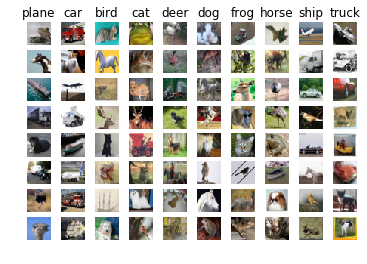

In [39]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Plane: Yes, many birds are misclassified as planes as they have similar shape (wings with a body). Many ships are also misclassified as planes as the background of planes is the sky(blue) whereas for ships it is the sea(also blue).

Car: Some of them make sense as trucks can also look like cars.

Bird, Cat, Frog: Do not make sense, the misclassifieds look quite different.

Deer: Make sense as deers are found in forestry, the misclassifieds have mostly green backgrounds.

Dog: Make sense since dogs are four-legged and most of the misclassifieds have four legs. They are also mostly white horses, which suggest most images for dogs during training were white.

Horse: Mostly make sense since the misclassifieds have long legs like horses.

Ship: Makes sense since background of misclassified are light blue like the ocean.

Truck: Some make sense as cars look like trucks at certain angles.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [4]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [14]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_val=-1
best_net = None
results = {}
import copy
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

#lr_list=[1e-1, 5e-1, 1]
#rs_list = [1e-3, 5e-3, 1e-2] 
#lr 1.000000e+00 reg 1.000000e-03  TA: 0.780000 VA: 0.548000  That's a huge learning rate by standards
#lr 1.000000e+00 reg 5.000000e-03  TA: 0.740000 VA: 0.547000 

#lr_list = np.linspace(7e-1, 3e0, 5)
#rs_list = np.linspace(2e-3, 4e-3, 5)
#lr 7.000000e-01 reg 2.000000e-03  TA: 0.690000 VA: 0.534000 
#lr 7.000000e-01 reg 2.500000e-03  TA: 0.710000 VA: 0.542000 
#lr 7.000000e-01 reg 3.000000e-03  TA: 0.720000 VA: 0.555000 
#lr 7.000000e-01 reg 3.500000e-03  TA: 0.680000 VA: 0.544000

#lr_list = np.linspace(7.5e-1,9.5e-1,5)
#rs_list = np.linspace(2.5e-3,3.5e-3,5)
#lr 8.000000e-01 reg 2.500000e-03  TA: 0.760000 VA: 0.551000

lr_list = [7.000000e-01]
rs_list = [3.000000e-03]
     
for lr in lr_list:
  for rs in rs_list:
    model = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = model.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=1000, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.95, verbose=True, reg=rs)
    if ( stats['val_acc_history'][-1] > best_val):
      best_lr, best_rs = lr, rs
      best_val = stats['val_acc_history'][-1]
      best_net = copy.deepcopy(model)
    results[(lr, rs)] = (stats['train_acc_history'][-1], stats['val_acc_history'][-1])

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302586
iteration 100 / 1000: loss 1.451958
iteration 200 / 1000: loss 1.495747
iteration 300 / 1000: loss 1.254590
iteration 400 / 1000: loss 1.361323
iteration 500 / 1000: loss 1.357557
iteration 600 / 1000: loss 1.269614
iteration 700 / 1000: loss 1.273118
iteration 800 / 1000: loss 1.383721
iteration 900 / 1000: loss 1.256214


In [15]:
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e  TA: %f VA: %f ' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 7.000000e-01 reg 3.000000e-03  TA: 0.790000 VA: 0.548000 
best validation accuracy achieved during cross-validation: 0.548000


In [16]:
# visualize the weights of the best network
print('Best learning rate: %f, Best regularization strength: %f' % (best_lr, best_rs))
best_net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=500, batch_size=200,
          learning_rate=best_lr, learning_rate_decay=0.95, verbose=True, reg=best_rs)
print()

Best learning rate: 0.700000, Best regularization strength: 0.003000
iteration 0 / 500: loss 1.271865
iteration 100 / 500: loss 1.398103
iteration 200 / 500: loss 1.313424
iteration 300 / 500: loss 1.388643
iteration 400 / 500: loss 1.326884



In [17]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.558
